In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

In [15]:
datasets = {}
model_names = ['Claude_3.5_Sonnet', 'GPT_3.5', 'GPT_4o']
file_paths = [
    '../Data/qna_dataset_Claude3.5Sonnet_final.csv',
    '../Data/qna_dataset_GPT3.5_final.csv', 
    '../Data/qna_dataset_GPT4o_final.csv'
]

### Phase 1: Data Structure & Quality Assessment

In [17]:
for model_name, file_path in zip(model_names, file_paths):
    try:
        df = pd.read_csv(file_path)
        datasets[model_name] = df
        print(f"✓ {model_name}: {df.shape[0]} rows × {df.shape[1]} columns")
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")

✓ Claude_3.5_Sonnet: 400 rows × 16 columns
✓ GPT_3.5: 400 rows × 16 columns
✓ GPT_4o: 400 rows × 16 columns


In [18]:
print("\n📉 Missing Values Analysis:")
for model_name, df in datasets.items():
    print(f"\n  {model_name}:")
    missing_summary = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_summary,
        'Missing_Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0]
    
    if len(missing_df) == 0:
        print("    ✓ No missing values detected")
    else:
        print("    ❌ Missing values found:")
        print(missing_df.to_string())


📉 Missing Values Analysis:

  Claude_3.5_Sonnet:
    ✓ No missing values detected

  GPT_3.5:
    ✓ No missing values detected

  GPT_4o:
    ✓ No missing values detected


##### SAMPLING BALANCE VERIFICATION

In [20]:
print("\n🎯 Domain Distribution Check:")
domain_summary = []
        
for model_name, df in datasets.items():
    domain_counts = df['domain'].value_counts().sort_index()
    domain_summary.append({
        'Model': model_name,
        **domain_counts.to_dict()
    })
    print(f"\n  {model_name}:")
    print(domain_counts.to_string())

# Create domain balance summary table
domain_df = pd.DataFrame(domain_summary).set_index('Model')
print(f"\n📊 Domain Balance Summary:")
print(domain_df.to_string())

# Check if perfectly balanced
if domain_df.nunique().nunique() == 1 and domain_df.nunique().iloc[0] == 1:
    print("✓ Perfect domain balance across all models")
else:
    print("❌ Domain imbalance detected")


🎯 Domain Distribution Check:

  Claude_3.5_Sonnet:
domain
General Knowledge    80
Healthcare           80
History              80
Pop Culture          80
Science              80

  GPT_3.5:
domain
General Knowledge    80
Healthcare           80
History              80
Pop Culture          80
Science              80

  GPT_4o:
domain
General Knowledge    80
Healthcare           80
History              80
Pop Culture          80
Science              80

📊 Domain Balance Summary:
                   General Knowledge  Healthcare  History  Pop Culture  Science
Model                                                                          
Claude_3.5_Sonnet                 80          80       80           80       80
GPT_3.5                           80          80       80           80       80
GPT_4o                            80          80       80           80       80
✓ Perfect domain balance across all models


##### DATA QUALITY VISUALIZATIONS

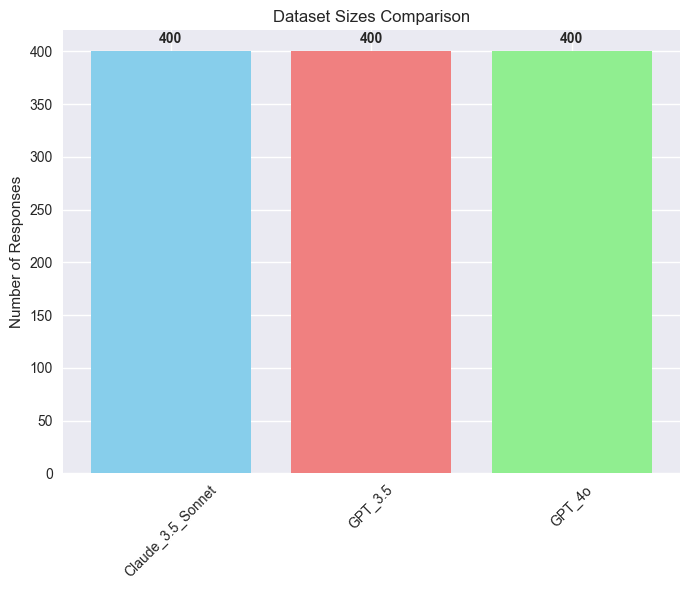

In [26]:
fig, ax = plt.subplots(figsize=(7, 6))  # Just one Axes instead of 2x2

# Dummy placeholders for illustration
model_names = list(datasets.keys())
dataset_sizes = [len(df) for df in datasets.values()]

ax.bar(model_names, dataset_sizes, color=['skyblue', 'lightcoral', 'lightgreen'])
ax.set_title('Dataset Sizes Comparison')
ax.set_ylabel('Number of Responses')
ax.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(dataset_sizes):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

##### Response length distribution

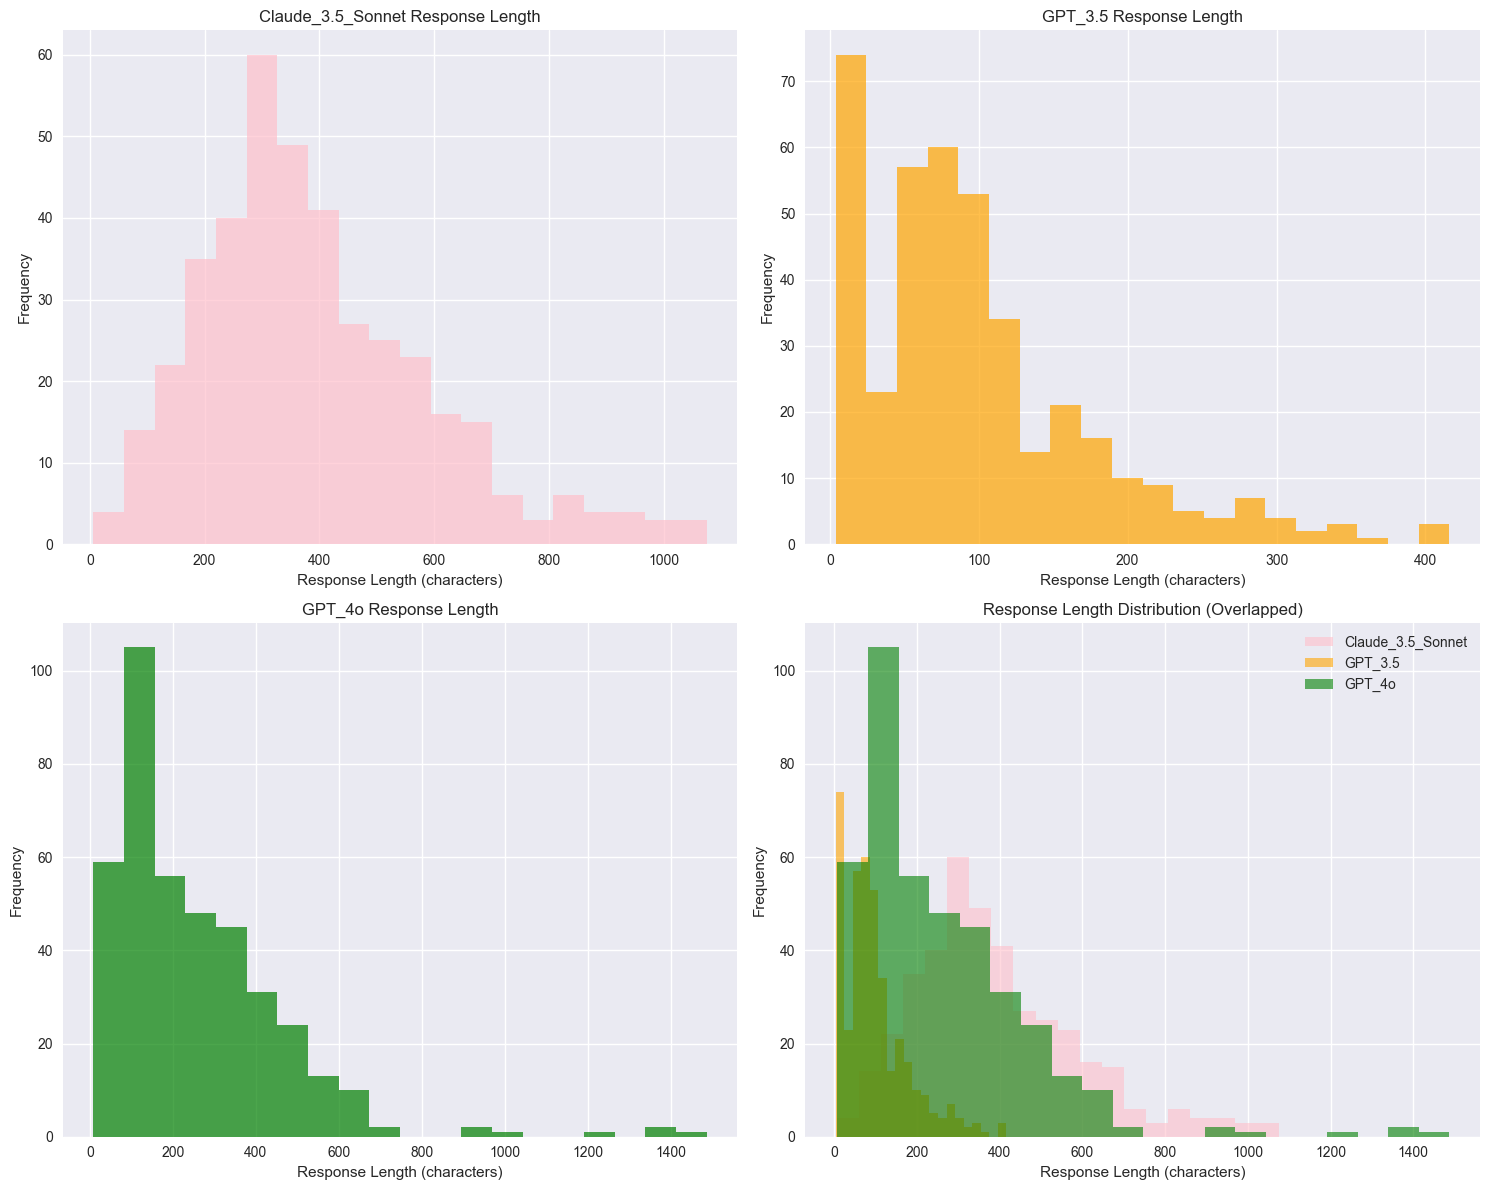

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
model_names = list(datasets.keys())
colors = ['pink', 'orange', 'green']

# Plot individual histograms
for i, (model_name, df) in enumerate(datasets.items()):
    row, col = divmod(i, 2)
    axes[row, col].hist(df['response_length'], bins=20, color=colors[i], alpha=0.7)
    axes[row, col].set_title(f'{model_name} Response Length')
    axes[row, col].set_xlabel('Response Length (characters)')
    axes[row, col].set_ylabel('Frequency')

# Plot all overlapping in [1,1]
for i, (model_name, df) in enumerate(datasets.items()):
    axes[1, 1].hist(df['response_length'], bins=20, alpha=0.6, label=model_name, color=colors[i])

axes[1, 1].set_title('Response Length Distribution (Overlapped)')
axes[1, 1].set_xlabel('Response Length (characters)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


**Response Length Characteristics:**
- **Claude 3.5 Sonnet** produces the longest responses, with a wide distribution peaking around 300-400 characters and extending significantly into longer responses (up to 1000+ characters)
- **GPT-3.5** has the shortest responses, heavily concentrated in the 0-100 character range with a sharp peak at the very beginning
- **GPT-4o** falls in the middle, with most responses clustered around 100-200 characters but with a notable tail extending to longer responses

**Key Insights:**

**Verbosity Ranking:** Claude 3.5 Sonnet > GPT-4o > GPT-3.5, with Claude being significantly more verbose than the others.

**Response Consistency:** GPT-3.5 shows the most consistent (short) response lengths, while Claude 3.5 Sonnet has the highest variability, suggesting it adapts response length more dynamically to the query.

**Distribution Shapes:** 
- GPT-3.5: Heavily right-skewed (most responses very short)
- GPT-4o: More balanced but still skewed toward shorter responses
- Claude 3.5 Sonnet: More normal distribution with a longer tail

**Practical Implications:**
- Claude 3.5 Sonnet appears designed to provide more comprehensive, detailed responses
- GPT-3.5 prioritizes brevity and efficiency
- GPT-4o strikes a middle ground between thoroughness and conciseness

This suggests different design philosophies: Claude optimizing for completeness and explanation depth, while GPT models (especially 3.5) prioritize concise, direct answers.

In [36]:
 print(f"\n📊 Question Type Balance Examination:")
print("-" * 40)

type_summary = {}

for model_name, df in datasets.items():
    if 'question_type' in df.columns:
        type_counts = df['question_type'].value_counts()
        type_pct = (type_counts / len(df)) * 100
        
        type_summary[model_name] = type_counts.to_dict()
        
        print(f"\n  🔍 {model_name}:")
        for qtype, count in type_counts.items():
            pct = type_pct[qtype]
            if pct > 90:
                bias_indicator = " ⚠️ HEAVY BIAS"
            elif pct > 75:
                bias_indicator = " ⚠️ Moderate bias"
            else:
                bias_indicator = ""
                
            print(f"    {qtype:15}: {count:3d} ({pct:5.1f}%){bias_indicator}")


📊 Question Type Balance Examination:
----------------------------------------

  🔍 Claude_3.5_Sonnet:
    closed-ended   : 391 ( 97.8%) ⚠️ HEAVY BIAS
    open-ended     :   9 (  2.2%)

  🔍 GPT_3.5:
    closed-ended   : 391 ( 97.8%) ⚠️ HEAVY BIAS
    open-ended     :   9 (  2.2%)

  🔍 GPT_4o:
    closed-ended   : 391 ( 97.8%) ⚠️ HEAVY BIAS
    open-ended     :   9 (  2.2%)


In [37]:
# 3. Question style balance check
print(f"\n📊 Question Style Balance Check:")
print("-" * 40)

style_summary = {}

for model_name, df in datasets.items():
    if 'question_style' in df.columns:
        style_counts = df['question_style'].value_counts()
        style_pct = (style_counts / len(df)) * 100
        
        style_summary[model_name] = style_counts.to_dict()
        
        print(f"\n  🎨 {model_name}:")
        for style, count in style_counts.items():
            pct = style_pct[style]
            if pct > 90:
                bias_indicator = " ⚠️ HEAVY BIAS"
            elif pct > 75:
                bias_indicator = " ⚠️ Moderate bias"
            else:
                bias_indicator = ""
                
            print(f"    {style:15}: {count:3d} ({pct:5.1f}%){bias_indicator}")


📊 Question Style Balance Check:
----------------------------------------

  🎨 Claude_3.5_Sonnet:
    qualitative    : 373 ( 93.2%) ⚠️ HEAVY BIAS
    quantitative   :  27 (  6.8%)

  🎨 GPT_3.5:
    qualitative    : 373 ( 93.2%) ⚠️ HEAVY BIAS
    quantitative   :  27 (  6.8%)

  🎨 GPT_4o:
    qualitative    : 373 ( 93.2%) ⚠️ HEAVY BIAS
    quantitative   :  27 (  6.8%)


In [38]:
print(f"\n📊 Question Nature Balance Check:")
print("-" * 40)

nature_summary = {}

for model_name, df in datasets.items():
    if 'question_nature' in df.columns:
        nature_counts = df['question_nature'].value_counts()
        nature_pct = (nature_counts / len(df)) * 100
        
        nature_summary[model_name] = nature_counts.to_dict()
        
        print(f"\n  🧠 {model_name}:")
        for nature, count in nature_counts.items():
            pct = nature_pct[nature]
            if pct > 90:
                bias_indicator = " ⚠️ HEAVY BIAS"
            elif pct > 75:
                bias_indicator = " ⚠️ Moderate bias"
            else:
                bias_indicator = ""
                
            print(f"    {nature:15}: {count:3d} ({pct:5.1f}%){bias_indicator}")
    


📊 Question Nature Balance Check:
----------------------------------------

  🧠 Claude_3.5_Sonnet:
    general        : 337 ( 84.2%) ⚠️ Moderate bias
    topical        :  63 ( 15.8%)

  🧠 GPT_3.5:
    general        : 337 ( 84.2%) ⚠️ Moderate bias
    topical        :  63 ( 15.8%)

  🧠 GPT_4o:
    general        : 337 ( 84.2%) ⚠️ Moderate bias
    topical        :  63 ( 15.8%)
